In [1]:
import (
	"encoding/csv"
	"fmt"
	"log"
	"math"
	"os"
	"strconv"

    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/vg"
)

In [2]:
func displayPlot(p *plot.Plot) {
    var buf bytes.Buffer
    c, err := p.WriterTo(10*vg.Inch, 4*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    
    if _, err := c.WriteTo(&buf); err != nil {
        panic(err)
    }

    gonbui.DisplayPNG(buf.Bytes())
}


MAE = 355.20



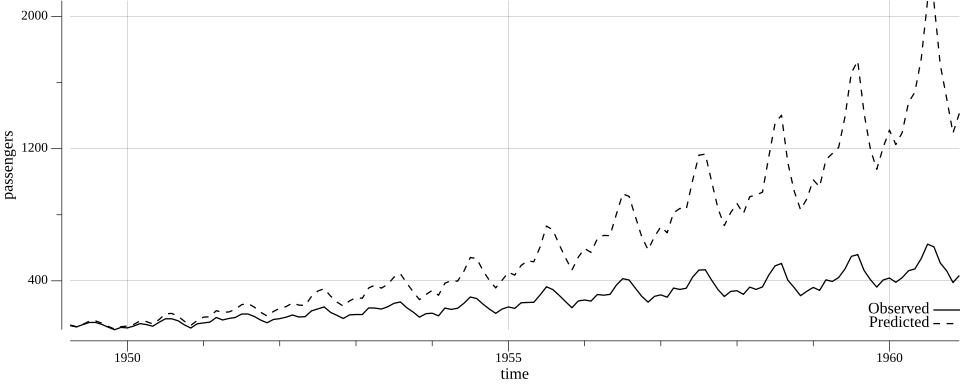

In [3]:
func main() {

	// Open the log differenced dataset file.
	transFile, err := os.Open("log_diff_series.csv")
	if err != nil {
		log.Fatal(err)
	}
	defer transFile.Close()

	// Create a CSV reader reading from the opened file.
	transReader := csv.NewReader(transFile)

	// Read in all of the CSV records
	transReader.FieldsPerRecord = 2
	transData, err := transReader.ReadAll()
	if err != nil {
		log.Fatal(err)
	}

	// Loop over the data predicting the transformed
	// observations.
	var transPredictions []float64
	for i, _ := range transData {

		// Skip the header and the first two observations
		// (because we need two lags to make a prediction).
		if i == 0 || i == 1 || i == 2 {
			continue
		}

		// Parse the first lag.
		lagOne, err := strconv.ParseFloat(transData[i-1][1], 64)
		if err != nil {
			log.Fatal(err)
		}

		// Parse the second lag.
		lagTwo, err := strconv.ParseFloat(transData[i-2][1], 64)
		if err != nil {
			log.Fatal(err)
		}

		// Predict the transformed variable with our trained AR model.
		transPredictions = append(transPredictions, 0.008159+0.234953*lagOne-0.173682*lagTwo)
	}

	// Open the original dataset file.
	origFile, err := os.Open("AirPassengers.csv")
	if err != nil {
		log.Fatal(err)
	}
	defer origFile.Close()

	// Create a CSV reader reading from the opened file.
	origReader := csv.NewReader(origFile)

	// Read in all of the CSV records
	origReader.FieldsPerRecord = 2
	origData, err := origReader.ReadAll()
	if err != nil {
		log.Fatal(err)
	}

	// pts* will hold the values for plotting.
	ptsObs := make(plotter.XYs, len(transPredictions))
	ptsPred := make(plotter.XYs, len(transPredictions))

	// Reverse the transformation and calculate the MAE.
	var mAE float64
	var cumSum float64
	for i := 4; i <= len(origData)-1; i++ {

		// Parse the original observation.
		observed, err := strconv.ParseFloat(origData[i][1], 64)
		if err != nil {
			log.Fatal(err)
		}

		// Parse the original date.
		date, err := strconv.ParseFloat(origData[i][0], 64)
		if err != nil {
			log.Fatal(err)
		}

		// Get the cumulative sum up to the index in
		// the transformed predictions.
		cumSum += transPredictions[i-4]

		// Calculate the reverse transformed prediction.
		predicted := math.Exp(math.Log(observed) + cumSum)

		// Accumulate the MAE.
		mAE += math.Abs(observed-predicted) / float64(len(transPredictions))

		// Fill in the points for plotting.
		ptsObs[i-4].X = date
		ptsPred[i-4].X = date
		ptsObs[i-4].Y = observed
		ptsPred[i-4].Y = predicted
	}

	// Output the MAE to standard out.
	fmt.Printf("\nMAE = %0.2f\n\n", mAE)

	// Create the plot.
	p := plot.New()
	p.X.Label.Text = "time"
	p.Y.Label.Text = "passengers"
	p.Add(plotter.NewGrid())

	// Add the line plot points for the time series.
	lObs, err := plotter.NewLine(ptsObs)
	if err != nil {
		log.Fatal(err)
	}
	lObs.LineStyle.Width = vg.Points(1)

	lPred, err := plotter.NewLine(ptsPred)
	if err != nil {
		log.Fatal(err)
	}
	lPred.LineStyle.Width = vg.Points(1)
	lPred.LineStyle.Dashes = []vg.Length{vg.Points(5), vg.Points(5)}

	// Save the plot to a PNG file.
	p.Add(lObs, lPred)
	p.Legend.Add("Observed", lObs)
	p.Legend.Add("Predicted", lPred)

    displayPlot(p)
}